This file implements DTW, Subsequence DTW, NSDTW, WSDTW, and SSDTW

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit, njit, float64, uint32, boolean

## DTW and Subsequence DTW

In [3]:
DTWDefaultSteps = np.array([[1, 1, 2],
                            [1, 2, 1]], dtype = np.uint32)

DTWDefaultWeights = np.array([2, 3, 3], dtype = np.float64)


subseqDTWDefaultSteps = np.array([[1, 1, 2],
                                  [1, 2, 1]], dtype = np.uint32)

subseqDTWDefaultWeights = np.array([1, 1, 2], dtype = np.float64)


MAX_FLOAT = float('inf')

In [4]:
# njit is equivalent to jit(nopython=True)
# This forces numba to compile in nopython mode, which is faster

# This line enforces input types. However, it does not work with optional parameters
#@njit((float64[:,::1], uint32[:,::1], float64[:], boolean))

@njit
def DTW_Cost_To_DAndB(C, Steps = DTWDefaultSteps, weights = DTWDefaultWeights, subsequence=False):
    '''
    Find the accumulated cost matrix and backtrace matrix from a cost matrix using Dynamic time warping
    
    Arguments:
    C -- The Cost matrix
    Steps -- The available steps, where the first row is the row steps, the second row is the column steps
    weights -- The weights of the steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
             
    Returns:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    '''
    
    '''
    Section for verifying input
    '''
    #Ensure parameters have correct dtypes and dimensions
    try:
        C = C.astype(np.float64)
        assert C.ndim == 2
    except:
        print("FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        weights = weights.astype(np.float64)
        assert weights.ndim == 1
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return
    
    # Ensure steps and weights sizes are appropriate
    stepsShape = Steps.shape
    numDifSteps = len(weights)
    
    if stepsShape[0] != 2:
        print("FAILURE: The size of the steps matrix is wrong - please pass in a 2-d numpy array with 2 rows")
        return
    if stepsShape[1] != numDifSteps:
        print("FAILURE: The number of steps and weights do not line up - please make sure that there are the same number of steps and weights")
        return
    
    '''
    Algorithm
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]

    # Define Relevant Variables
    numRows = C.shape[0]
    numCols = C.shape[1]
    
    numDifSteps = len(weights)
    maxRowStep = max(rowSteps)
    maxColStep = max(colSteps)
    
    # Set up accumulated cost matrix D and backtrace matrix B
    D = np.ones((numRows + maxRowStep, numCols + maxColStep), dtype = np.float64) * MAX_FLOAT
    B = np.zeros((numRows, numCols), dtype = np.uint32)
    
    # Fill up D and B
    if subsequence:  # Initialize entire bottom row of D for subsequence
        D[maxRowStep, maxColStep:] = C[0,:]
    else:
        D[maxRowStep, maxColStep] = C[0,0]  # Initialize bottom corner if for standard DTW
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = D[row, col]
            bestCostIndex = 0
            # Go through each step, find the best one
            for stepIndex in range(numDifSteps):
                costForStep = D[row - rowSteps[stepIndex], col - colSteps[stepIndex]] + weights[stepIndex] * C[row - maxRowStep, col - maxColStep]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # Save best cost and step
            D[row,col] = bestCost
            B[row - maxRowStep, col - maxColStep] = bestCostIndex
    
    # Return accumulated cost matrix D and backtrace matrix B
    return D[maxRowStep:, maxColStep:], B

In [5]:
# This line enforces input types. However, it does not work with optional parameters
#@njit((float64[:,::1], uint32[:,::1], uint32[:,::1], boolean, uint32))

@njit
def DTW_Backtrace(D, B, Steps=DTWDefaultSteps, subsequence=False, startCol=-1):
    '''
    Backtrace through an accumulated cost matrix and backtrace matrix to find a path
    
    Arguments:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    Steps -- The available steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
    startCol -- The column to begin backtracing from, or -1 if not specified
    
    Returns:
    fwdPath -- A 2d numpy array storing the optimal path. The first row is the path through the rows.
            The second row is the path through the columns
    '''
    
    '''
    Section for verifying input
    '''
    # Ensure parameters have correct dtypes and dimensions
    try:
        D = D.astype(np.float64)
        assert D.ndim == 2
    except:
        print("FAILURE: The type of the accumulated cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        B = B.astype(np.uint32)
        assert B.ndim == 2
    except:
        print("FAILURE: The type of the backtrace matrix is wrong - please pass in a 2-d numpy array")
        return
    
    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    # Ensure that D and B are the same shape
    if D.shape != B.shape:
        print("FAILURE: The accumulated cost matrix and backtrace matrix are not the same size - please make sure their sizes match")
        return
    
    
    '''
    Backtrace through D and B
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]
    
    # Initialize variables
    numRows = D.shape[0]
    numCols = D.shape[1]
    
    curRow = numRows - 1  # Always start at last row
    curCol = numCols - 1  # Standard DTW: Start at top-right corner
    if startCol > 0:
        curCol = startCol
    elif subsequence:  # Subsequence: Choose lowest cost of top row
        curCol = np.argmin(D[numRows-1,:])
    
    endCol = curCol
    endCost = D[curRow, curCol]
    stepsInPath = 1
    stepIndex = 0
    done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
    path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol
    
    # Backtrace
    while not done:
        if D[curRow, curCol] == MAX_FLOAT:  # No path exists to current location
            print('A path is not possible')
            break
        
        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = B[curRow, curCol]
        curRowStep = rowSteps[curStepIndex]
        curColStep = colSteps[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
        
    # reverse the path (a matrix with two rows) and return it
    fwdPath = np.fliplr(path[:, 0:stepsInPath])
    return fwdPath
    #return fwdPath, endCol, endCost

In [6]:
@njit
def DTW(F1, F2, Steps = DTWDefaultSteps, weights = DTWDefaultWeights, subsequence = False):
    '''
    Run DTW on two feature matrices
    
    Arguments:
    F1 -- Feature Matrix 1
    F2 -- Feature Matrix 2
    Steps -- The steps matrix. The first row is the steps in along the rows,
             the second row is the steps along the columns
    weights -- The weights for the steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
    
    Returns:
    path -- A 2d numpy array storing the optimal path. The first row is the path through the rows.
            The second row is the path through the columns
    '''
    #TODO: Verify Parameters
    
    # Compute Cost Matrix
    C = 1 - F1.T @ F2 # cos distance metric
    
    # Get D and B
    D, B = DTW_Cost_To_DAndB(C, Steps = Steps, weights = weights, subsequence=subsequence)
    
    # Backtrace and return
    return DTW_Backtrace(D, B, Steps=Steps, subsequence=subsequence)

### Test DTW on Random Feature Matrices

In [7]:
F1 = np.random.rand(12, 10000)
norm_factor = np.sqrt(np.sum(F1*F1, axis=0))
F1 = F1 / norm_factor

F2 = np.random.rand(12, 10000)
norm_factor = np.sqrt(np.sum(F2*F2, axis=0))
F2 = F2 / norm_factor

In [8]:
path = DTW(F1, F2)

In [9]:
_, wp = lb.sequence.dtw(F1, F2, metric = 'cosine', step_sizes_sigma=DTWDefaultSteps.T, weights_mul = DTWDefaultWeights)

In [10]:
np.allclose(path, np.fliplr(wp.T))

True

As desired, our implementation's output matches the output from librosa

### Test Subsequence DTW on Random Feature Matrices

In [11]:
SDTWpath = DTW(F1[0:2000], F2, Steps = subseqDTWDefaultSteps, weights=subseqDTWDefaultWeights, subsequence=True)

In [12]:
_, SDTWwp = lb.sequence.dtw(F1[0:2000], F2, metric = 'cosine', step_sizes_sigma=subseqDTWDefaultSteps.T, weights_mul = subseqDTWDefaultWeights, subseq=True)

In [13]:
np.allclose(SDTWpath, np.fliplr(SDTWwp.T))

True

As desired, our implementation's output matches the output from librosa

## Non-ordered Segmental DTW

In [14]:
@njit
def NSDTW(F1, F2, segments, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights):
    '''
    Runs a non-ordered segmental DTW between query and reference features matrices
    
    Arguments:
    F1 -- The query features matrix (will be segmented)
    F2 -- The reference features matrix
    segments -- The number of segments to divide F1 into
    Steps -- The allowed steps
    weights -- The weights for the steps
    
    Returns:
    path -- The optimal non-ordered, segmented alignment path between F1 and F2
    '''
    #TODO: Verify parameters
    
    # Initialize path
    # make as large as could need, then chop at the end
    path = np.zeros((2, F1.shape[1] + (segments * F2.shape[1])), dtype=np.uint32)
    stepsInPath = 0
    
    segLength = int(np.round(F1.shape[1] / segments))
    
    # Subsequence DTW each segment
    for i in range(segments-1):
        segStart = i * segLength
        currentSeg = F1[:,segStart:segStart + segLength]
        pathSeg = DTW(currentSeg, F2, Steps = Steps, weights = weights, subsequence = True)
        
        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + segStart
        
        # Append fragment to full path
        stepsInPathSeg = pathSeg.shape[1]
        path[:,stepsInPath:stepsInPath+stepsInPathSeg] = pathSeg
        # stepsInPath keeps track of how long the path is, and where to put new path segments
        stepsInPath = stepsInPath + stepsInPathSeg
    
    # The final fragment handles the rest of the query, which may be a slightly different size
    segStart = (segments - 1) * segLength
    currentSeg = F1[:,segStart:]
    pathSeg = DTW(currentSeg, F2, Steps = Steps, weights = weights, subsequence = True)
    
    # Add offset to row indices
    pathSeg[0,:] = pathSeg[0,:] + segStart
    
    # Append fragment to full path
    stepsInPathSeg = pathSeg.shape[1]
    path[:,stepsInPath:stepsInPath+stepsInPathSeg] = pathSeg
    stepsInPath = stepsInPath + stepsInPathSeg
    
    # Chop off any extra space at the end of the path
    return path[:,:stepsInPath]

In [15]:
path = NSDTW(F1, F2, 5)

<ipython-input-14-7d7210b3b7ed>:29: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  pathSeg = DTW(currentSeg, F2, Steps = Steps, weights = weights, subsequence = True)
<ipython-input-14-7d7210b3b7ed>:29: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  pathSeg = DTW(currentSeg, F2, Steps = Steps, weights = weights, subsequence = True)


In [16]:
C = 1 - F1.T @ F2

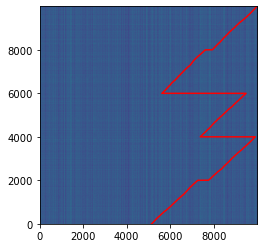

In [17]:
plt.imshow(C, origin="lower");
plt.plot(path[1,:], path[0,:], 'r');